In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df=pd.read_csv("Clean Data (4).csv")

In [ ]:
df['Code Article'].nunique()

311

In [ ]:
reserve=df.copy()

In [ ]:

df['Date']=pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('uint32')
df['DayOfYear'] = df['Date'].dt.dayofyear.astype('uint32')
df['Day']=df['Date'].dt.day.astype('uint32')
df['week'] = pd.to_datetime(df['Date']).dt.isocalendar().week.astype('uint32')
df['Month'] = df['Date'].dt.month.astype('uint32')
df['Year']=pd.to_datetime(df['Date']).dt.year.astype('uint32')


**CATEGORICAL FEATURES**

In [ ]:
mapping_dict = {
    'Entrepôt AERO CLUB': 1,
    'Entrepôt Ci-Gusta TUNIS': 2,
    'Entrepôt DB HD TUNIS': 3,
    'Entrepôt DB SD TUNIS': 4,
    'Entrepôt Gourmandise TUNIS': 5,
    'Entrepôt MAISON FONDANT HD': 6,
    'Entrepôt Maison Fondant SD Tun': 7,
    'Entrepôt PLAN B COFFE TUN': 8,
    'Entrepôt PLAN B TUN': 9
}
inverse_mapping_dict = {v: k for k, v in mapping_dict.items()}

df['Entrepôt'] = df['Entrepôt'].map(mapping_dict)

df.sort_values(by=['Entrepôt', 'Code Article', 'Date'],inplace=True)
df = df.groupby(['Entrepôt', 'Code Article']).apply(lambda x: x)

In [ ]:
df['Référence Mesure']=df['Référence Mesure'].isin(['kiloGramme', 'kiloG', 'KG'])

In [ ]:
holidays = ['2019-08-10', '2022-07-08', '2023-06-27', '2019-11-09', '2022-10-07',
            '2023-09-26', '2019-08-30', '2022-07-29', '2023-07-18', '2024-04-09',
            '2023-12-20', '2022-05-01', '2019-06-03']

df['is_holiday'] = df['Date'].isin(holidays).astype(int)

additional_holidays = {
    (1, 1),   # January 1st
    (5, 1),   # May 1st
    (12, 17), # December 17th
    (3, 20),  # March 20th
    (4, 9),   # April 9th
    (7, 25)   # July 25th
}
for month, day in additional_holidays:
    df.loc[(df['Date'].dt.month == month) & (df['Date'].dt.day == day), 'is_holiday'] = 1

In [ ]:
ramadan_periods = [
    (pd.to_datetime("2019-05-05"), pd.to_datetime("2019-06-03")),
    (pd.to_datetime("2023-03-22"), pd.to_datetime("2023-04-20")),
    (pd.to_datetime("2024-03-12"), pd.to_datetime("2024-04-10"))
]
df['is_ramadan'] = 0
for start_date, end_date in ramadan_periods:
    df['is_ramadan'] |= ((df['Date'] >= start_date) & (df['Date'] <= end_date))


In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
#  GROUP THEM BY AUTOCORRELATION LAG OF WANTED VALUE
def selector(sd, lower, shift):
  df=sd.copy()
  df['Date']=pd.to_datetime(df['Date'])
  article_sales = df.groupby(['Code Article','Entrepôt', 'Date'])['Utés'].sum().reset_index()
  article_sales = article_sales.set_index('Date').groupby(['Code Article','Entrepôt']).resample('D').sum().fillna(0)
  article_sales = article_sales.reset_index(drop=True)

  def compute_lag1_autocorr(data):  return acf(data, nlags=shift)[-1] if len(data) > 1 else None

  article_sales['lag1_autocorr'] = article_sales.groupby(['Code Article','Entrepôt'])['Utés'].transform(compute_lag1_autocorr)
  filtered_articles = article_sales[(article_sales['lag1_autocorr'] >= lower)]
  unique_filtered_articles = filtered_articles[['Code Article','Entrepôt']].drop_duplicates()

  return unique_filtered_articles

In [ ]:
# selected_articles = selector(df, 0.6, 1)
# df['lag_corr']=df['Code Article'].isin(selected_articles)

In [ ]:
# number of sales points that article is present in
df['Entrepôt_Count'] = df.groupby('Code Article')['Entrepôt'].transform('nunique')


**AGGREGATED FEAUTURES**


---




In [ ]:
article_days_sold = df.groupby(['Code Article', 'Entrepôt'])['Date'].nunique().reset_index()
article_days_sold.rename(columns={'Date': 'DaysSold'}, inplace=True)
total_days_open = df.groupby('Entrepôt')['Date'].nunique().reset_index()
total_days_open.rename(columns={'Date': 'TotalDaysOpen'}, inplace=True)

frequency_of_sales_ratio = pd.merge(article_days_sold, total_days_open, on='Entrepôt')
frequency_of_sales_ratio['FrequencyOfSales'] = (frequency_of_sales_ratio['DaysSold'] / frequency_of_sales_ratio['TotalDaysOpen'] )
df = pd.merge(df, frequency_of_sales_ratio[['Code Article', 'Entrepôt', 'FrequencyOfSales']], on=['Code Article', 'Entrepôt'], how='left')

In [ ]:
# creating rolling averages; var, std, and mean over a window of 7 days to capture the preceeding week's variations
df['rolling_var'] = df.groupby([ 'Entrepôt','Code Article'])['Utés'].shift(1).rolling(window=7, min_periods=1).var()
df['rolling_std'] = df.groupby(['Entrepôt','Code Article'])['Utés'].shift(1).rolling(window=7, min_periods=1).std()
df['rolling_mean']=df.groupby(['Entrepôt','Code Article' ])['Utés'].shift(1).rolling(window=7, min_periods=1).mean()

In [ ]:
# most recent day this article was sold lag
df['lag_var']=df.groupby(['Entrepôt','Code Article'])['Utés'].shift(1)
df['lag_var1']=df.groupby(['Entrepôt','Code Article'])['Utés'].shift(2)
df['lag_var2']=df.groupby(['Entrepôt','Code Article'])['Utés'].shift(3)

In [ ]:
#filling missing dates values with 0s for every Entrepôt/ Code Article combination to create true lags, not time unorganized lags.

all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
unique_articles = df['Code Article'].unique()

unique_entrepots_per_article = df.groupby('Code Article')['Entrepôt'].unique()

all_combinations = []
for article, entrepots in unique_entrepots_per_article.items():
    for date in all_dates:
        for entrepot in entrepots:
            all_combinations.append((date, article, entrepot))

all_combinations_df = pd.DataFrame(all_combinations, columns=['Date', 'Code Article', 'Entrepôt'])
merged_df = pd.merge(df, all_combinations_df, on=['Date', 'Code Article', 'Entrepôt'], how='outer')

merged_df.sort_values(by=['Code Article', 'Date', 'Entrepôt'], inplace=True)

merged_df['Utés'].fillna(0, inplace=True)

df=merged_df.copy()

In [ ]:
#creating the true lags
def lagger(lags,lag_column,df):
  for i in lags:
    df.loc[(df['Year'] >= 2023), f'Utés_lag_{i}_day'] = df[df['Year']>=2023].groupby(['Entrepôt','Code Article'])[lag_column].shift(i)
    df.loc[(df['Year'] == 2019), f'Utés_lag_{i}_day'] = df[df['Year']==2019].groupby(['Entrepôt','Code Article'])[lag_column].shift(i)

lagger([1,2,14,28,8,7],'Utés',df)

In [ ]:
df.drop(df[df['Utés']==0].index,inplace=True)

In [ ]:
#creating expanding averages; min, max, mean, and st
# df['MAX']=df['Utés_lag_1_day'].cummax()
df['MEAN']=df['Utés_lag_1_day'].expanding().mean()
# df['MIN']=df['Utés_lag_1_day'].cummin()
df['STD']=df['Utés_lag_1_day'].expanding().std()


In [ ]:
#creating a difference between last day and the day before it
df['diff_prev']=(df['lag_var']-df['lag_var1'])
df['diff_prev1']=(df['lag_var1']-df['lag_var2'])

#creating yesterday's variation with the day before and same day in last week's variation with the day before it
df['variance_1_day']=(df['Utés_lag_1_day']-df['Utés_lag_2_day'])/df['Utés_lag_2_day']
df['variance_7_day']=(df['Utés_lag_7_day']-df['Utés_lag_8_day'])/df['Utés_lag_8_day']

#creating a rolling 1 week variation for every article
# df['r_variance_7'] = df.groupby([ 'Entrepôt','Code Article'])['variance_1_day'].shift(1).rolling(window=7, min_periods=1).mean().reset_index(drop=True)

In [ ]:
cat_feats=['is_holiday','is_ramadan','Bar_Code','Référence Mesure','Département']
for i in cat_feats:
  df[i]=df[i].astype(bool)
for i in['Day','Year','week','Entrepôt','Entrepôt_Count','Code Article','DayOfYear','Month','DayOfWeek']:
  df[i]=df[i].astype('uint32')

**ENCODING**

---



In [ ]:
# Rayon_encoder=LabelEncoder()
# df['Rayon']=Rayon_encoder.fit_transform(df['Rayon'])

#dropping insignificant columns
df.drop(['Description','Bar_Code','Date','Département','is_holiday','Rayon'],axis=1,inplace=True)

**SPILITTING**

---



In [ ]:
chosen=df.copy()
year=2024
X_train=chosen[chosen['Year']!=year].drop(columns=['Utés','Montant'])
y_train=chosen[chosen['Year']!=year]['Utés']
X_test=chosen[chosen['Year']==year].drop(columns=['Utés','Montant'])
y_test=chosen[chosen['Year']==year]['Utés']

In [ ]:
chosen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222980 entries, 14064 to 215195
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Entrepôt          222980 non-null  uint32 
 1   Code Article      222980 non-null  uint32 
 2   Référence Mesure  222980 non-null  bool   
 3   Utés              222980 non-null  float64
 4   Montant           222980 non-null  float64
 5   DayOfWeek         222980 non-null  uint32 
 6   DayOfYear         222980 non-null  uint32 
 7   Day               222980 non-null  uint32 
 8   week              222980 non-null  uint32 
 9   Month             222980 non-null  uint32 
 10  Year              222980 non-null  uint32 
 11  is_ramadan        222980 non-null  bool   
 12  Entrepôt_Count    222980 non-null  uint32 
 13  FrequencyOfSales  222980 non-null  float64
 14  rolling_var       222977 non-null  float64
 15  rolling_std       222977 non-null  float64
 16  rolling_mean      222

**NORMALIZATION**:

---



In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
def scale(data,scaler):
  numerical_columns = data.select_dtypes(include=['float64']).columns
  scaler.fit(data[numerical_columns])
  data[numerical_columns]=scaler.transform(data[numerical_columns])
  data['Code Article'] = data['Code Article'].astype(int)
scaler = RobustScaler()
scale(X_train,scaler)
scale(X_test,scaler)

**USED FUNCTIONS**

In [ ]:
def plot_pred(y_test,y_pred):
  x_ax = range(len(y_test))
  plt.figure(figsize=(12, 6))
  plt.plot(x_ax, y_test, label="original")
  plt.plot(x_ax, y_pred, label="predicted")
  plt.title("Sales test and predicted data")
  plt.xlabel('X')
  plt.ylabel('Utés')
  plt.legend(loc='best',fancybox=True, shadow=True)
  plt.grid(True)
  plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, mean_absolute_percentage_error, max_error
def scores(y_test,y_pred):
  mse = mean_squared_error(y_test, y_pred)
  print("Mean Squared Error: ", mse)
  mae = mean_absolute_error(y_test, y_pred)
  print("Mean Absolute Error: " , mae)
  me = max_error(y_test, y_pred)
  print("Maximum Error: " , me)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  print("Mean Absolute percentage Error: " , mape)
  r2 = r2_score(y_test, y_pred)
  print("r sqaured: ", r2)
  return {"Mean Squared Error: ": mse, "Mean Absolute Error: " : mae,"Maximum Error: " : me,"Mean Absolute percentage Error: " :mape,"r squared":r2}

In [ ]:
def save_metrics(metrics, columns,params,note='',filename='performance_metrics.txt'):
  with open(filename, "a") as file:
    file.write(f"-------------------\n{note}\n")
    file.write("Metrics:\n")
    file.write(f"{metrics}\n")
    file.write("Columns:\n")
    file.write(f"{columns}\n")
    file.write("Parameters:\n")
    file.write(f"{params}\n")
    file.write("\n")


In [ ]:
def decomposer(samplee, scaler,model):
    samp = samplee.copy()
    sample=samplee.copy()
    sample.drop(columns=['Montant','Utés'],inplace=True)
    numerical_columns = sample.select_dtypes(include=['float64']).columns
    sample[numerical_columns] = scaler.transform(sample[numerical_columns])
    sample['Code Article'] = sample['Code Article'].astype(int)
    predictions = model.predict(sample)
    sample['Utés'] = predictions
    sample[numerical_columns] = scaler.inverse_transform(sample[numerical_columns])
    for i in range(len(samplee)):
      print(samp['Year'].values[i],'-',samp['Month'].values[i],samp['Day'].values[i],'-',inverse_mapping_dict[samp['Entrepôt'].values[i]],samp['Code Article'].values[i], '  ', samp['Utés'].values[i], '  ', sample['Utés'].values[i])
    return None

In [ ]:
cat_feats=X_train.select_dtypes(include=['uint32','bool'])
cat_feats=cat_feats.columns.to_list()
cat_feats

['Entrepôt',
 'Référence Mesure',
 'DayOfWeek',
 'DayOfYear',
 'Day',
 'week',
 'Month',
 'Year',
 'is_ramadan',
 'Entrepôt_Count']

**Training XGBoost**

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'count:poisson',
    'eval_metric': 'mape',
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'max_bin': 256,
}
num_round = 1000
bst = xgb.train(param, dtrain, num_round)

In [ ]:
xgbpreds = bst.predict(dtest)
metrics=scores(y_test, xgbpreds)
param['num_rounds']=num_round
save_metrics(metrics,X_train.columns,param,note='',filename='xgboost.txt')

Mean Squared Error:  373.80510336497895
Mean Absolute Error:  6.435181062236992
Maximum Error:  350.6417682170868
Mean Absolute percentage Error:  0.6733007986130487
r sqaured:  0.37602165173704416


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

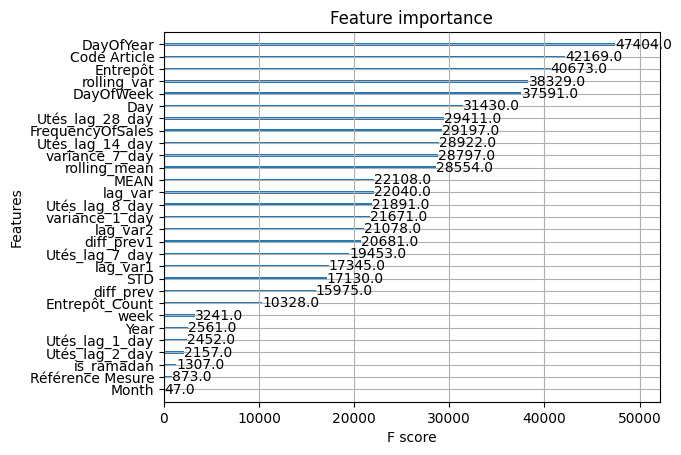

In [ ]:
xgb.plot_importance(bst)

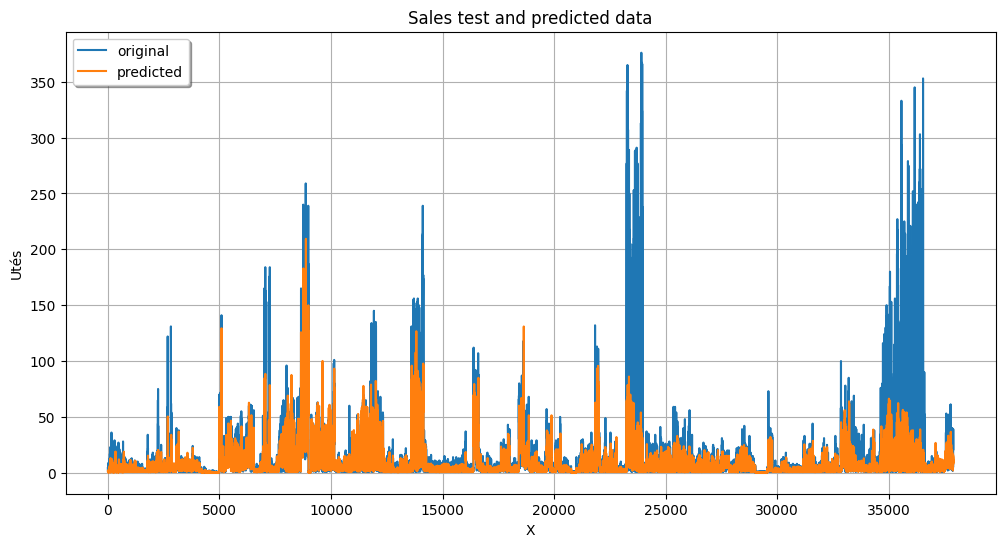

In [ ]:
plot_pred(y_test,(xgbpreds))

**Training LightGBM**

---


In [ ]:
train=lgb.Dataset(X_train,label=y_train,categorical_feature=cat_feats)
test=lgb.Dataset(X_test,label=y_test,categorical_feature=cat_feats)
print(X_train.shape,'  ',y_train.shape,'--',X_test.shape,'  ',y_test.shape)
params = {
    'objective': 'regression_l1',
    'metric': ['l1','l2'],
    'max_depth':10,
    'boosting': 'gbdt',
    'force_col_wise':True,
    'num_leaves': 60,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

num_round = 850
lgb_model = lgb.train(params,
                      num_boost_round=num_round,
                      train_set=train,
                      valid_sets= [train,test])

(185076, 30)    (185076,) -- (37904, 30)    (37904,)


In [ ]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

In [ ]:
metrics=scores(y_test, y_pred)
params=dict(params,num_round=num_round)
save_metrics(metrics,X_train.columns,params,'')

Mean Squared Error:  146.12630615902316
Mean Absolute Error:  4.8200127453270944
Maximum Error:  320.42017115464853
Mean Absolute percentage Error:  0.799448607975854
r sqaured:  0.7560770296229811


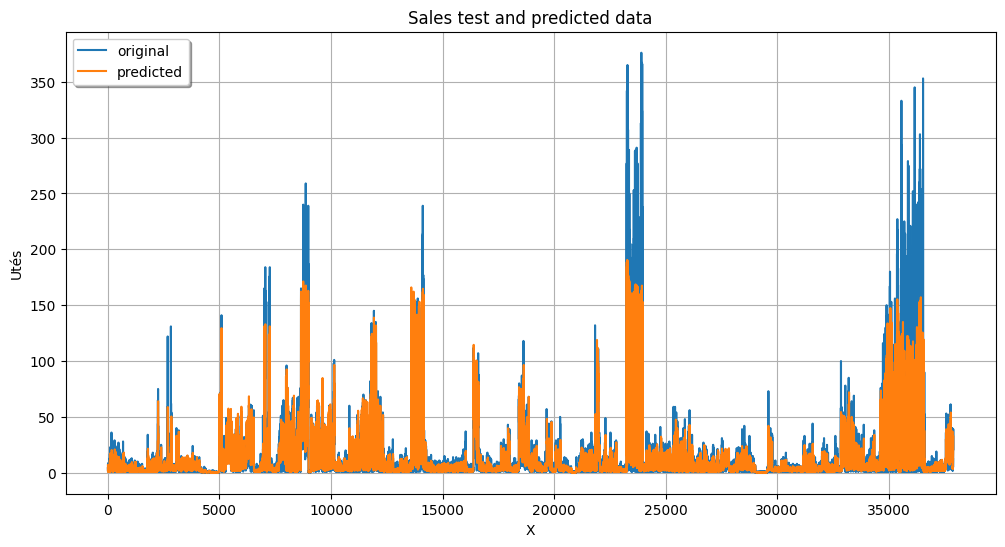

In [ ]:
plot_pred(y_test,y_pred)

In [ ]:
decomposer(chosen[(chosen['Year']!=2024)].sample(10),scaler,lgb_model)


2023 - 7 9 - Entrepôt DB HD TUNIS 420    4.0    9.492747494625016
2023 - 2 13 - Entrepôt DB HD TUNIS 2028    1.0    1.9404348541914507
2023 - 8 17 - Entrepôt DB HD TUNIS 384    24.0    15.811152315916079
2023 - 2 5 - Entrepôt DB SD TUNIS 4821    4.0    4.03827520132008
2019 - 8 7 - Entrepôt Ci-Gusta TUNIS 1725    4.0    10.289812062478797
2019 - 11 7 - Entrepôt Ci-Gusta TUNIS 1687    96.0    95.91696812509872
2023 - 1 9 - Entrepôt DB HD TUNIS 1375    51.0    48.014810779893374
2019 - 4 29 - Entrepôt Ci-Gusta TUNIS 16    19.0    20.200652718182212
2019 - 1 31 - Entrepôt Maison Fondant SD Tun 1425    1.0    1.3496629044951154
2023 - 5 18 - Entrepôt Maison Fondant SD Tun 4754    1.0    3.6082709913448534


In [ ]:
article=4932
print(reserve[reserve['Code Article']==article]['Entrepôt'].unique())
print(reserve[(reserve['Code Article']==article)]['Description'].unique()[0])
reserve[(reserve['Code Article']==article)].sort_values(by='Date').tail(20)

['Entrepôt PLAN B TUN']
Plan-B- Le Mexicain


,Date,Entrepôt,Code Article,Description,Bar_Code,Département,Rayon,Référence Mesure,Utés,Montant
220684,2024-04-02,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,1.0,25.500000
220685,2024-04-03,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,10.0,246.639344
220686,2024-04-04,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,3.0,74.827869
220687,2024-04-05,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,7.0,165.409958
220688,2024-04-07,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,9.0,226.155738
220689,2024-04-08,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,5.0,119.888060
220690,2024-04-09,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,5.0,124.155738
220691,2024-04-10,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,10.0,253.327869
220692,2024-04-11,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,12.0,300.983607
220693,2024-04-12,Entrepôt PLAN B TUN,4932,Plan-B- Le Mexicain,Prepared,SOLIDE,SANDWICH CHAUD,Utés,12.0,300.983607


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

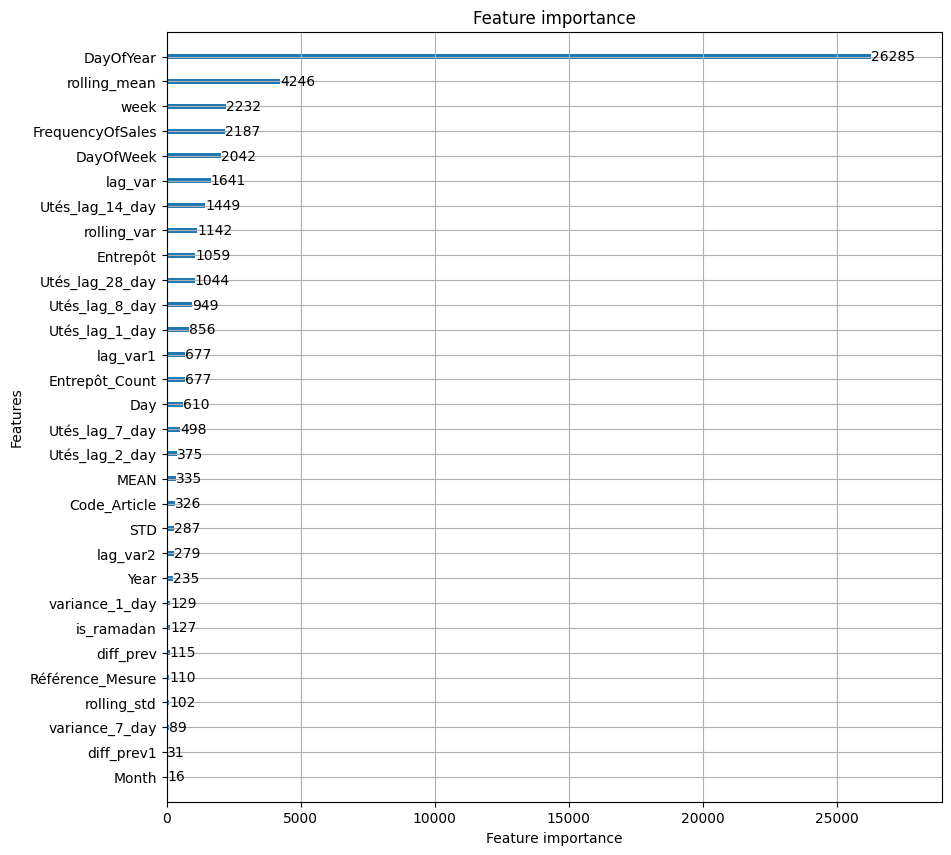

In [ ]:
lgb.plot_importance(lgb_model,importance_type='split',figsize=(10,10))

In [ ]:
gain = lgb_model.feature_importance(importance_type='gain')
split = lgb_model.feature_importance(importance_type='split')
feature_names = lgb_model.feature_name()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain, 'Split':split})
feature_importance_df = feature_importance_df.sort_values(by='Gain', ascending=False)
feature_importance_df

,Feature,Gain,Split
14,rolling_mean,1.320489e+07,4246
4,DayOfYear,1.910724e+06,26285
15,lag_var,1.480424e+06,1641
18,Utés_lag_1_day,3.250872e+05,856
12,rolling_var,2.497780e+05,1142
20,Utés_lag_14_day,1.963713e+05,1449
3,DayOfWeek,1.821973e+05,2042
16,lag_var1,1.769749e+05,677
11,FrequencyOfSales,1.386116e+05,2187
19,Utés_lag_2_day,1.281279e+05,375


In [ ]:
def mape(group):
  true_values = group['y']
  predicted_values = group['pred']
  return mean_absolute_percentage_error(true_values,predicted_values)

t=X_test.copy()
t['y']=y_test.copy()
t['pred']=y_pred.copy()
ls=t.groupby(['Entrepôt','Code Article']).apply(mape)
ls.describe()

count    622.000000
mean       0.880610
std        0.871346
min        0.040545
25%        0.504466
50%        0.679053
75%        0.889067
max        7.180515
dtype: float64

In [ ]:
rftrain=X_train.fillna(0).drop(columns=cat_feats)
rftest=X_test.fillna(0).drop(columns=cat_feats)

rf_params = {
  'n_estimators': 100,
  'min_samples_split': 20,
  'min_samples_leaf': 10,
  'max_features': 0.5,
  'random_state': 42,
  'verbose':1
}

rf = RandomForestRegressor(**rf_params)
rf.fit(rftrain, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min


RandomForestRegressor(max_features=0.5, min_samples_leaf=10,
                      min_samples_split=20, random_state=42, verbose=1)

In [ ]:
rf_pred = rf.predict(rftest)
rfscores=scores(y_test,rf_pred)

save_metrics(rfscores,rftrain.columns,rf_params,note='',filename='randomforest.txt')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Mean Squared Error:  146.59988329761805
Mean Absolute Error:  5.254433214352748
Maximum Error:  291.3652953644166
Mean Absolute percentage Error:  1.0259405937696777
r sqaured:  0.7552865056893712


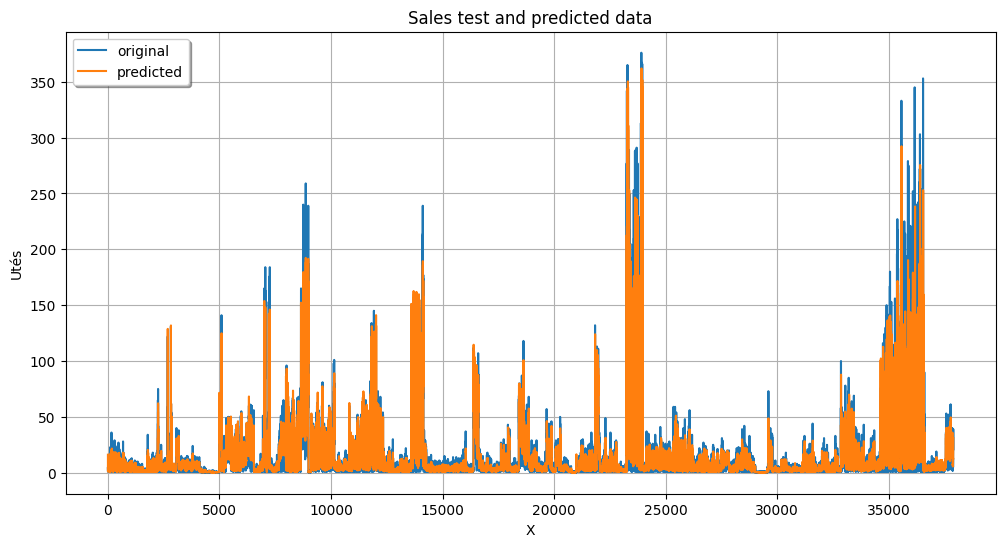

In [ ]:
plot_pred(y_test,rf_pred)